# **Amazon Baby Product Sentiment Analysis**

**1. Giriş**

Duygu analizi (Sentiment Analysis), Doğal Dil İşleme (Natural Language Processing – NLP) çalışmalarının bir alt araştırma alanı olarak karşımıza çıkmakta olup, Fikir Madenciliği (Opinion Mining) olarak da bilinen duygu analizi ile belirli bir konu hakkındaki sözlü veya yazılı metinlerin içerisindeki öznel dil ögelerini anlamlandırılabilmektir [1]. Bir yazarın veya bir yazının belirli bir konuya yönelik tutumunun olumlu (positive), olumsuz(negative), tarafsız (neutral) olarak değerlendirilmesi için bir metin parçasıyla belirtilen görüşleri/ifadeleri çeşitli algoritmalar aracılığı ile hesaplayıp tanımlama ve sınıflandırma süreçlerine verilen genel bir tanımdır [2].

<div>
<img src="https://miro.medium.com/max/1378/1*jHzNpL-KagnaHUSHzPTPkA.jpeg" width="600"/>
</div>



**1.1 Problem Tanımı**

Bu notebookda, bir dizi anahtar polarize edici kelime kullanarak bir duygu analizi modeli eğitilecek ve bu kelimelerin her birine öğrenilen ağırlıkları doğrulayarak elde edilen daha basit sınıflandırıcının sonuçları tüm kelimeler kullanılarak eğitilen model ile karşılaştırılacaktır.


[Data Source](https://www.kaggle.com/ronnie3rg/amazon-baby-sentiment-analysis)

**İçindekiler**

2.   [Veri Ön İşlemesi ve Analizi](#cell-id1)

    2.1. [Veri Analizi](#cell-id1.1)

    2.2. [Eğitim-Test Verisi Ayrımı](#cell-id1.2)


3.   [Lojistik Regresyon](#cell-id2) 

    3.1. [Model Doğruluğu](#cell-id2.1)

    3.2. [Seçilen alt küme ile Lojistik Regresyon](#cell-id2.1)

[Referanslar](#cell-id3)



## Import the Modules

In [1]:
import numpy as np
import pandas as pd
import string
import plotly.offline as py
import plotly
import plotly.graph_objs as go
from plotly.subplots import make_subplots
import plotly.express as px
import plotly.figure_factory as ff
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, auc

In [2]:
def make_confusion_matrix(cf,
                          group_names=None,
                          categories='auto',
                          count=True,
                          percent=True,
                          cbar=True,
                          xyticks=True,
                          xyplotlabels=True,
                          sum_stats=True,
                          figsize=None,
                          cmap='Blues',
                          title=None):
    '''
    This function will make a pretty plot of an sklearn Confusion Matrix cm using a Seaborn heatmap visualization.
    Arguments
    ---------
    cf:            confusion matrix to be passed in
    group_names:   List of strings that represent the labels row by row to be shown in each square.
    categories:    List of strings containing the categories to be displayed on the x,y axis. Default is 'auto'
    count:         If True, show the raw number in the confusion matrix. Default is True.
    normalize:     If True, show the proportions for each category. Default is True.
    cbar:          If True, show the color bar. The cbar values are based off the values in the confusion matrix.
                   Default is True.
    xyticks:       If True, show x and y ticks. Default is True.
    xyplotlabels:  If True, show 'True Label' and 'Predicted Label' on the figure. Default is True.
    sum_stats:     If True, display summary statistics below the figure. Default is True.
    figsize:       Tuple representing the figure size. Default will be the matplotlib rcParams value.
    cmap:          Colormap of the values displayed from matplotlib.pyplot.cm. Default is 'Blues'
                   See http://matplotlib.org/examples/color/colormaps_reference.html
                   
    title:         Title for the heatmap. Default is None.
    '''


    # CODE TO GENERATE TEXT INSIDE EACH SQUARE
    blanks = ['' for i in range(cf.size)]

    if group_names and len(group_names)==cf.size:
        group_labels = ["{}\n".format(value) for value in group_names]
    else:
        group_labels = blanks

    if count:
        group_counts = ["{0:0.0f}\n".format(value) for value in cf.flatten()]
    else:
        group_counts = blanks

    if percent:
        group_percentages = ["{0:.2%}".format(value) for value in cf.flatten()/np.sum(cf)]
    else:
        group_percentages = blanks

    box_labels = [f"{v1}{v2}{v3}".strip() for v1, v2, v3 in zip(group_labels,group_counts,group_percentages)]
    box_labels = np.asarray(box_labels).reshape(cf.shape[0],cf.shape[1])


    # CODE TO GENERATE SUMMARY STATISTICS & TEXT FOR SUMMARY STATS
    if sum_stats:
        #Accuracy is sum of diagonal divided by total observations
        accuracy  = np.trace(cf) / float(np.sum(cf))

        #if it is a binary confusion matrix, show some more stats
        if len(cf)==2:
            #Metrics for Binary Confusion Matrices
            precision = cf[1,1] / sum(cf[:,1])
            recall    = cf[1,1] / sum(cf[1,:])
            f1_score  = 2*precision*recall / (precision + recall)
            stats_text = "\n\nAccuracy={:0.3f}\nPrecision={:0.3f}\nRecall={:0.3f}\nF1 Score={:0.3f}".format(
                accuracy,precision,recall,f1_score)
        else:
            stats_text = "\n\nAccuracy={:0.3f}".format(accuracy)
    else:
        stats_text = ""


    # SET FIGURE PARAMETERS ACCORDING TO OTHER ARGUMENTS
    if figsize==None:
        #Get default figure size if not set
        figsize = plt.rcParams.get('figure.figsize')

    if xyticks==False:
        #Do not show categories if xyticks is False
        categories=False


    # MAKE THE HEATMAP VISUALIZATION
    plt.figure(figsize=figsize)
    sns.heatmap(cf,annot=box_labels,fmt="",cmap=cmap,cbar=cbar,xticklabels=categories,yticklabels=categories)

    if xyplotlabels:
        plt.ylabel('True label')
        plt.xlabel('Predicted label' + stats_text)
    else:
        plt.xlabel(stats_text)
    
    if title:
        plt.title(title)

In [3]:
def plot_actualvspredicted(y_test, y_pred):
    fig = px.scatter(x=y_test, y=y_pred, labels={'x': 'Actual', 'y': 'Prediction'})
    fig.update_layout(
        title='Simple actual vs predicted',
        title_font_size=18,
        width=600,
        height=500)
    fig.show()

<a name="cell-id1"></a>
## **2.** Data Preprocessing & Analysis

<a name="cell-id1.1"></a>
### **2.1** Data Analysis

In [15]:
URL = 'https://d396qusza40orc.cloudfront.net/phoenixassets/amazon_baby.csv'
data = pd.read_csv(URL)
data

name  ... rating
0                                Planetwise Flannel Wipes  ...      3
1                                   Planetwise Wipe Pouch  ...      5
2                     Annas Dream Full Quilt with 2 Shams  ...      5
3       Stop Pacifier Sucking without tears with Thumb...  ...      5
4       Stop Pacifier Sucking without tears with Thumb...  ...      5
...                                                   ...  ...    ...
183526  Baby Teething Necklace for Mom Pretty Donut Sh...  ...      5
183527  Baby Teething Necklace for Mom Pretty Donut Sh...  ...      5
183528   Abstract 2 PK Baby / Toddler Training Cup (Pink)  ...      5
183529  Baby Food Freezer Tray - Bacteria Resistant, B...  ...      5
183530  Best 2 Pack Baby Car Shade for Kids - Window S...  ...      5

[183531 rows x 3 columns]

In [16]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 183531 entries, 0 to 183530
Data columns (total 3 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   name    183213 non-null  object
 1   review  182702 non-null  object
 2   rating  183531 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 4.2+ MB


In [17]:
data.describe()

rating
count  183531.000000
mean        4.120448
std         1.285017
min         1.000000
25%         4.000000
50%         5.000000
75%         5.000000
max         5.000000

In [18]:
data.isnull().sum()

name      318
review    829
rating      0
dtype: int64

In [19]:
data = data.dropna()

En çok incelenen 5 ürünü bulalım.

In [20]:
print("Top 5 Amazon Baby Product's Review Frequency\n")
data['name'].value_counts().head()

Top 5 Amazon Baby Product's Review Frequency



Vulli Sophie the Giraffe Teether                                            779
Simple Wishes Hands-Free Breastpump Bra, Pink, XS-L                         560
Infant Optics DXR-5 2.4 GHz Digital Video Baby Monitor with Night Vision    558
Baby Einstein Take Along Tunes                                              545
Cloud b Twilight Constellation Night Light, Turtle                          517
Name: name, dtype: int64

Derecelendirmelerine göre en çok incelenen ürünün sıklık grafiğini inceleyelim.

In [21]:
top1_reviews_freq = data[data['name']=='Vulli Sophie the Giraffe Teether']
fig = px.histogram(top1_reviews_freq, x="rating", nbins=10)
fig.update_layout(
    title='Number of reviews',
    title_font_size=18,
    yaxis_title="Reviews Frequency",
    xaxis_title="Rating",
    width=400,
    height=400,)
fig.show()

Yaklaşım sınıflandırıcısı oluşturmak için önce verilerden bir sözcük sayısı vektörü oluşturun. Yani, her inceleme için benzersiz kelimelerin sayısını sayın. 

In [22]:
vectorizer = CountVectorizer(analyzer='word', ngram_range=(1, 1))
word_count = []
for index, row in data.iterrows():
    text = row['review']
    try:
        cv_fit = vectorizer.fit_transform([text])
        word_list = vectorizer.get_feature_names_out() 
        count_list = np.asarray(cv_fit.sum(axis=0))[0]
        word_count.append(dict(zip(word_list, count_list)))
    except:
        word_count.append(np.nan)
data['word_count'] = word_count
data

name  ...                                         word_count
0                                Planetwise Flannel Wipes  ...  {'12': 1, 'about': 1, 'also': 1, 'and': 5, 'ar...
1                                   Planetwise Wipe Pouch  ...  {'and': 3, 'bags': 1, 'came': 1, 'disappointed...
2                     Annas Dream Full Quilt with 2 Shams  ...  {'and': 2, 'anyone': 1, 'bed': 1, 'comfortable...
3       Stop Pacifier Sucking without tears with Thumb...  ...  {'about': 1, 'and': 3, 'anything': 1, 'approac...
4       Stop Pacifier Sucking without tears with Thumb...  ...  {'all': 2, 'allow': 1, 'an': 1, 'and': 2, 'bin...
...                                                   ...  ...                                                ...
183526  Baby Teething Necklace for Mom Pretty Donut Sh...  ...  {'and': 1, 'baby': 1, 'cool': 1, 'for': 1, 'gr...
183527  Baby Teething Necklace for Mom Pretty Donut Sh...  ...  {'accessible': 1, 'accessory': 1, 'and': 5, 'a...
183528   Abstract 2 PK Baby / Toddler Training Cup (Pink)  ...  {'and': 2, 'company': 1, 'cool': 1, 'for': 1, ...
183529  Baby Food Freezer Tray - Bacteria Resistant, B...  ...  {'ability': 1, 'advantage': 1, 'also': 3, 'am'...
183530  Best 2 Pack Baby Car Shade for Kids - Window S...  ...  {'also': 1, 'and': 1, 'bought': 1, 'but': 2, '...

[182384 rows x 4 columns]

In [11]:
fig = px.histogram(data, x="rating", nbins=10)
fig.update_layout(
    title='Number of reviews for all products',
    title_font_size=14,
    yaxis_title="Reviews Frequency",
    xaxis_title="Rating",
    width=500,
    height=460,)
fig.show()

Derecelendirmelerine göre en çok incelenen 5 ürünün sıklık grafiğini çizdirelim. 

In [23]:
top5_products = data['name'].value_counts().head().index.to_list()
for product in top5_products:
    reviews_freq = data[data['name']==product]
    fig = px.histogram(reviews_freq, x="rating", nbins=10)
    fig.update_layout(
        title='Number of reviews for ' + product,
        title_font_size=12,
        yaxis_title="Reviews Frequency",
        xaxis_title="Rating",
        width=500,
        height=460,)
    fig.show()

3 * olarak derecelendirilmiş tüm ürünleri (yani nötr yaklaşım içerenleri) yoksayalım ve sıklık grafiğini yeniden çizdirelim.

In [25]:
fig = px.histogram(data, x="rating", nbins=10)
fig.update_layout(
    title='Number of reviews for all products',
    title_font_size=14,
    yaxis_title="Reviews Frequency",
    xaxis_title="Rating",
    width=500,
    height=460,)
fig.show()

In [24]:
data = data[data['rating'] != 3]
for product in top5_products:
    reviews_freq = data[data['name']==product]
    fig = px.histogram(reviews_freq, x="rating", nbins=10)
    fig.update_layout(
        title='Number of reviews for ' + product,
        title_font_size=12,
        yaxis_title="Reviews Frequency",
        xaxis_title="Rating",
        width=500,
        height=460,)
    fig.show()

<div>
<img src="https://us.123rf.com/450wm/tatianasun/tatianasun1612/tatianasun161200284/68937981-smiley-emoticons-icon-positive-and-negative-vector-isolated-illustration-of-red-and-green-different-.jpg?ver=6
" width="200"/>
</div>

3*'dan büyük olan derecelendirmeleri "pozitif", 3*'dan küçük olan derecelendirmeleri "negatif" olarak tanımlayalım. Bu pozitif ve negatif olarak belirlenen bilgilerle ("sentiment" adlı) yeni bir sütun oluşturalım. 

In [26]:
data['sentiment'] = data['rating'].apply(lambda rating : 1 if rating > 3 else 0)
data

name  ... sentiment
1                                   Planetwise Wipe Pouch  ...         1
2                     Annas Dream Full Quilt with 2 Shams  ...         1
3       Stop Pacifier Sucking without tears with Thumb...  ...         1
4       Stop Pacifier Sucking without tears with Thumb...  ...         1
5       Stop Pacifier Sucking without tears with Thumb...  ...         1
...                                                   ...  ...       ...
183526  Baby Teething Necklace for Mom Pretty Donut Sh...  ...         1
183527  Baby Teething Necklace for Mom Pretty Donut Sh...  ...         1
183528   Abstract 2 PK Baby / Toddler Training Cup (Pink)  ...         1
183529  Baby Food Freezer Tray - Bacteria Resistant, B...  ...         1
183530  Best 2 Pack Baby Car Shade for Kids - Window S...  ...         1

[165679 rows x 5 columns]

Ürünlerin sıklık grafiğini sentiment kolonuna göre çizdirelim.

In [28]:
colors = ['rgba(255, 65, 54, 0.5)', 'rgba(44, 160, 101, 0.5)']    
fig = go.Figure()
fig.add_trace(go.Bar(
    x=['Negative (0)'],
    y=[data[data['sentiment'] == 0].count().review],
    name='Negative',
    marker_color=colors[0]
))
fig.add_trace(go.Bar(
    x=['Positive (1)'],
    y=[data[data['sentiment'] == 1].count().review],
    name='Positive',
    marker_color=colors[-1]
))
fig.update_layout(
    title='Number of reviews for all data',
    title_font_size=14,
    yaxis_title="Reviews Frequency",
    xaxis_title="Rating",
    width=500,
    height=460,)
fig.show()

In [19]:
colors = ['rgba(255, 65, 54, 0.5)', 'rgba(44, 160, 101, 0.5)']
for product in top5_products:
    reviews_freq = data[data['name']==product]
    fig = go.Figure()
    fig.add_trace(go.Bar(
        x=['Negative (0)'],
        y=[reviews_freq[reviews_freq['sentiment'] == 0].count().review],
        name='Negative',
        marker_color=colors[0]
    ))
    fig.add_trace(go.Bar(
        x=['Positive (1)'],
        y=[reviews_freq[reviews_freq['sentiment'] == 1].count().review],
        name='Positive',
        marker_color=colors[-1]
    ))
    fig.update_layout(
        title='Number of reviews for ' + product,
        title_font_size=12,
        yaxis_title="Reviews Frequency",
        xaxis_title="Rating",
        width=500,
        height=460,)
    fig.show()

<a name="cell-id1.2"></a>
### **2.2** Train/Test Split

Verinin %80'i modeli eğitmek için kullanılırken, %20'si ondan oluşturulan modeli test etmek için kullanılmak üzere bölünür.

In [29]:
seed = 0 # The “seed” is a starting point for the sequence and the guarantee is that if you start from the same seed you will get the same sequence of numbers.

X = data['review']
y = data['sentiment']

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed)

vectorizer = CountVectorizer()
x_train = vectorizer.fit_transform(x_train)
x_test = vectorizer.transform(x_test)

<a name="cell-id2"></a>
## **3.** Logistic Classifier

In [ ]:
sentiment_model = LogisticRegression()
sentiment_model.fit(x_train, y_train)

In [22]:
sentiment_model.coef_

array([[-4.76992091e-01, -6.52220057e-02,  1.09498857e-02, ...,
         3.90158550e-05,  1.48513626e-03, -6.03168041e-04]])

In [31]:
sentiment_model.intercept_

array([1.25794008])

57294 adet öznitelik ve bu özniteliklerin ağırlıklarının dağılımı aşağıda verilmiştir.

In [ ]:
model_coef = pd.DataFrame(sentiment_model.coef_)
group_labels = ['Coefficients']
fig = ff.create_distplot(model_coef.values, group_labels, bin_size=.2)
fig.update_layout(
    title_font_size=18,
    yaxis_title="Frequency",
    xaxis_title="Coefficients",
    width=800,
    height=800,)
fig.show()

Output hidden; open in https://colab.research.google.com to view.

<a name="cell-id2.1"></a>
####**3.1** Model Evaluation

In [32]:
y_pred = sentiment_model.predict(x_test)

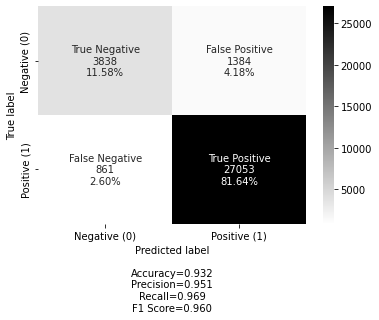

In [33]:
labels = ['True Negative', 'False Positive', 'False Negative', 'True Positive']
categories = ['Negative (0)', 'Positive (1)']
make_confusion_matrix(confusion_matrix(y_test, y_pred, labels=[0, 1]), 
                      group_names=labels,
                      categories=categories, 
                      cmap='binary')

In [28]:
y_score = sentiment_model.predict_proba(x_test)[:, 1]

fpr, tpr, thresholds = roc_curve(y_test, y_score)

fig = px.area(
    x=fpr, y=tpr,
    title=f'ROC Curve (AUC={auc(fpr, tpr):.4f})',
    labels=dict(x='False Positive Rate', y='True Positive Rate'),
    width=700, height=500
)
fig.add_shape(
    type='line', line=dict(dash='dash'),
    x0=0, x1=1, y0=0, y1=1
)

fig.update_yaxes(scaleanchor="x", scaleratio=1)
fig.update_xaxes(constrain='domain')
fig.show()

In [35]:
probs = sentiment_model.predict_proba(x_test)
probs_ = [probs[i][pred] for i, pred in enumerate(y_pred)]
plot_actualvspredicted(y_test, probs_)

In [41]:
fig = px.scatter(x=probs[:, 0], y=probs[:, 1])
fig.update_layout(
    title="Predicted Probabilities for Each Class",
    title_font_size=18,
    yaxis_title="Negative (0)",
    xaxis_title="Positive (1)",
    width=500,
    height=500,)
fig.show()

In [47]:
fig = go.Figure(data=[go.Scatter3d(x=probs_, 
                                   y=y_pred, 
                                   z=y_test,
                                   mode='markers')])
fig.update_layout(
    title="Probabilities vs Predicted Class vs Actual Class",
    title_font_size=18,
    scene = dict(
                xaxis_title='Probabilities',
                yaxis_title='Predicted Class',
                zaxis_title='Actual Class'))
fig.show()

In [ ]:
top1_reviews_freq = top1_reviews_freq.sort_values('rating', ascending=False)
for index, row in top1_reviews_freq.iterrows():
    text = row['review']
    sentiment =  1 if row['rating'] > 3 else 0
    text = vectorizer.transform([text])
    print('Predicted sentiment: {}, Actual sentiment: {}'.format(sentiment_model.predict(text)[0], sentiment))

Predicted sentiment: 1, Actual sentiment: 1
Predicted sentiment: 1, Actual sentiment: 1
Predicted sentiment: 1, Actual sentiment: 1
Predicted sentiment: 1, Actual sentiment: 1
Predicted sentiment: 1, Actual sentiment: 1
Predicted sentiment: 1, Actual sentiment: 1
Predicted sentiment: 1, Actual sentiment: 1
Predicted sentiment: 1, Actual sentiment: 1
Predicted sentiment: 1, Actual sentiment: 1
Predicted sentiment: 1, Actual sentiment: 1
Predicted sentiment: 1, Actual sentiment: 1
Predicted sentiment: 0, Actual sentiment: 1
Predicted sentiment: 1, Actual sentiment: 1
Predicted sentiment: 1, Actual sentiment: 1
Predicted sentiment: 1, Actual sentiment: 1
Predicted sentiment: 1, Actual sentiment: 1
Predicted sentiment: 1, Actual sentiment: 1
Predicted sentiment: 1, Actual sentiment: 1
Predicted sentiment: 1, Actual sentiment: 1
Predicted sentiment: 1, Actual sentiment: 1
Predicted sentiment: 1, Actual sentiment: 1
Predicted sentiment: 1, Actual sentiment: 1
Predicted sentiment: 1, Actual s

İlk (most positive review) eleştiri oldukça olumlu görünüyor. İkinci inceleme için (most negative review) derecelendirmeden tahmin edebileceğimiz gibi, inceleme oldukça olumsuz.

In [ ]:
print('Most positive review: \n', top1_reviews_freq['review'].iloc[0])
print('\nMost negative review: \n', top1_reviews_freq['review'].iloc[-1])

Most positive review: 
 He likes chewing on all the parts especially the head and the ears! It has helped when he has been cranky because of teething. Great purchase!

Most negative review: 
 Totally overpriced for what it is.  Go to Petsmart and get a squeaky toy for $.99.  My 7-month old doesn\'t even like it.  She wants her $2 rattles instead.  This thing is totally useless.  Don\'t waste your money!


<a name="cell-id2.2"></a>
####**3.2** Subset of the words 

Train-Test Split

In [ ]:
selected_words=['awesome', 'great', 'fantastic', 'amazing', 
                'love', 'horrible', 'bad', 'terrible', 
                'awful', 'wow', 'hate']

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed)

vectorizer = CountVectorizer(vocabulary=selected_words)
x_train = vectorizer.fit_transform(x_train)
x_test = vectorizer.transform(x_test)

Yalnızca selected_words kullanarak verilerden başka bir sözcük sayısı vektörü oluşturalım. selected_words veri kümesinde bulunan kelimelerden en çok hangi kelime ve en az hangi kelime kullanılır?

In [ ]:
def get_used_words(corpus, vocabulary=None):
    """
    Return the most used word and least used word.
    
    >>> get_used_words(["I love Python", 
                        "Python is a language programming", 
                        "Hello world", "I love the world"]) 
               
    >>> [('python', 2),
         ('language', 1)]
    """
    vec = CountVectorizer(vocabulary=vocabulary).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key = lambda x: x[1], reverse=True)

    return [words_freq[0], words_freq[-1]]

most_used, least_used = get_used_words(X , selected_words)
print('The most commonly used word is "{}" and has been used {} times. \nThe least commonly used word is "{}" and has been used {} times.'.format(most_used[0], most_used[-1], least_used[0], least_used[-1]))

The most commonly used word is "great" and has been used 55677 times. 
The least commonly used word is "wow" and has been used 425 times.


In [ ]:
selected_words_model = LogisticRegression()
selected_words_model.fit(x_train, y_train)

Her öznitelik için öğrenilen ağırlıkları çizdirelim. Öğrenilen katsayıların selected_words veri kümesindeki 11 kelimeden  hangisi en olumlu ağırlığı aldı? Hangisi en negatif ağırlığa sahip? Bu değerler mantıklı mı? 

Grafikden görüldüğü üzere en olumlu ağırlığı alan kelime "love" kelimesi olurken en olumsuz ağırlığa sahip olan kelime "horrible" oldu.  "wow" kelimesi negatif bir ağırlığa sahip olması dikkat çekmektedir. Geri kalan kelimelerin ağırlıkları oldukça mantıklı durmaktadır.

In [ ]:
colors = ['Positive' if c > 0 else 'Negative' for c in selected_words_model.coef_[0]]

fig = px.bar(
    x=selected_words, y=selected_words_model.coef_[0], color=colors,
    color_discrete_sequence=['green', 'red'],
    labels=dict(x='Feature', y='Coefficient'),
    title='Weight of each feature for predicting sentiments'
)
fig.update_layout(
    title_font_size=18,
    width=700,
    height=500)
fig.show()


"selected_words_model"  doğruluğu nedir? Tüm kelimelerin kullanılarak öğrenilen sentiment_model doğruluğu nedir? Bu problemdeki majority  class sınıflandırıcısının doğruluğu nedir? Bu modelleri temel yaklaşımla (yani çoğunluk sınıflandırıcısıyla (majority class classifier)) ile karşılaştırınız? 

(Çoğunluk sınıflandırıcısı, her veri noktasının en yaygın sınıftan olduğunu tahmin eder. Bu temeldir ve kesinlikle verilerden öğrendiğimiz modellerle yenmek istediğimiz bir şeydir.) 


In [ ]:
y_pred = selected_words_model.predict(x_test)

In [ ]:
labels = ['True Negative', 'False Positive', 'False Negative', 'True Positive']
categories = ['Negative (0)', 'Positive (1)']
make_confusion_matrix(confusion_matrix(y_test, y_pred, labels=[0, 1]), 
                      group_names=labels,
                      categories=categories, 
                      cmap='binary')

In [ ]:
y_score = selected_words_model.predict_proba(x_test)[:, 1]

fpr, tpr, thresholds = roc_curve(y_test, y_score)

fig = px.area(
    x=fpr, y=tpr,
    title=f'ROC Curve (AUC={auc(fpr, tpr):.4f})',
    labels=dict(x='False Positive Rate', y='True Positive Rate'),
    width=700, height=500
)
fig.add_shape(
    type='line', line=dict(dash='dash'),
    x0=0, x1=1, y0=0, y1=1
)

fig.update_yaxes(scaleanchor="x", scaleratio=1)
fig.update_xaxes(constrain='domain')
fig.show()

**Doğruluk Karşılaştırması**

"sentiment_model" için doğruluk puanı 0.932'dir, burada "selected_words_model" için doğruluk puanı 0.849'dur. Dolayısıyla, "sentiment_model"'in "selected_words_model"'ine göre daha iyi doğruluğa sahip olduğu anlamına gelir. Ayrıca "selected_words_model", 0.007 gibi bir değerle baseline doğruluğu geçmiştir. Fakat oldukça yakın olduğu görülmektedir. Tüm bu karşılaştırmaların sonucunda, "sentiment_model", seçilen bazı kelimelerle eğitilen "selected_words_model"'e göre daha iyi duygu analizi yaptığı sonucuna varırız.

In [ ]:
positive_label = len(y_test[y_test == 1])
negative_label = len(y_test[y_test == 0])
baseline_accuracy = positive_label * 1./(positive_label + negative_label)
colors = ['seagreen', '#d62728']
fig = go.Figure(data=[go.Pie(labels=['Positive', 'Negative'], 
                             values=[positive_label, negative_label])])

fig.update_layout(
    title='Number of sentiments for baseline accuracy',
    title_font_size=18,
    width=500,
    height=500,
    annotations=[dict(text='Baseline accuracy is {0:.3f}'.format(baseline_accuracy), 
                      x=0.28, y=0.5, font_size=10, showarrow=False)])

fig.update_traces(hoverinfo='label+percent', 
                  textinfo='value', 
                  textfont_size=20,
                  hole=.5,
                  marker=dict(colors=colors, 
                              line=dict(color='#000000', 
                                        width=2)))

fig.show()

<a name="cell-id3"></a>
#**Referanslar**

1.   [Duygu Analizi](https://starlangyazilim.com/duygu-analizi-sentiment-analysis-nedir/#:~:text=Duygu%20analizi%20(Sentiment%20Analysis)%2C,metinlerin%20i%C3%A7erisindeki%20%C3%B6znel%20dil%20%C3%B6geleri)
2.   [Duygu Analizi - 2](https://ardabatuhandemir.medium.com/duygu-analizi-sentiment-anaylsis-nedir-68a59a8b0142)
3.   [A Complete Sentiment Analysis Algorithm in Python with Amazon Product Review Data: Step by Step](https://towardsdatascience.com/a-complete-sentiment-analysis-algorithm-in-python-with-amazon-product-review-data-step-by-step-2680d2e2c23b)
4.   [Sentiment Analysis with TuriCreate](https://github.com/shiv-source/Product-sentiment-analysis/blob/master/Product-sentiment-reviews.ipynb)
5.   [Sentiment Analysis with TuriCreate (Amazon Baby's Product)](https://www.kaggle.com/sumitmohod22/sentiment-analysis-using-turicreate)
6.   [ROC Curve in Plotly](https://plotly.com/python/roc-and-pr-curves/)
7.   [Designing your own sentiment analysis tool](https://colab.research.google.com/github/littlecolumns/ds4j-notebooks/blob/master/sentiment-analysis-is-bad/notebooks/Designing%20your%20own%20sentiment%20analysis%20tool.ipynb#scrollTo=SN97D_qp-C-7)
8.   [Sentiment Analysis with scikit-learn](https://www.kaggle.com/ashirwadsangwan/sentiment-analysis)
